### Objective: To train additional models. 

Previously, I trained univariate linear models, In this notebook, I will train some nonlinear models. In the near future, I will start an MLFlow pipeline for training. 

In this I am also exploring the effect of choosing a limited subset of features, to increase explainability. 


##### Import modules and then data 

In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from shutil import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import plotly.express as px
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate, RepeatedKFold, RepeatedStratifiedKFold, KFold
from sklearn.metrics import RocCurveDisplay
from joblib import dump, load
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

##### Load and partition the data 

In [420]:
DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)
descriptors_fname = data_path/'MPK190_descriptors_V13_heparin_column.pq'
descriptors_df = pd.read_parquet(descriptors_fname)
metadata = data_path/'MPK190-v13-metadata.pq'
metadata_df =pd.read_parquet(metadata)

assert (metadata_df.index==descriptors_df.index).mean()==1
heparin = metadata_df[['Hep RTT']]


mean_zeros = (descriptors_df==0).mean()
cols = mean_zeros.index[mean_zeros<1]
descriptors_df = descriptors_df[cols]

### partition the data
heparin['Label'] = heparin['Hep RTT']>1.0
X_train, X_test, y_train, y_test = train_test_split(descriptors_df, heparin, shuffle=True, stratify=heparin['Label'], train_size = 60, random_state =42)
distribution = pd.concat([y_train.mean(), y_test.mean()], axis = 1)
distribution.columns = ['Train', 'Test']
distribution

,Train,Test
Hep RTT,0.9974,1.006333
Label,0.4000,0.444444


#### Functions for training models

In [3]:

def drop_zeros(s):
    """ drop zeros from series
    Args:
        s (pd.Series): 
    Returns:
        pd.Series: 
    """
    return s[s!=0]

def select_cols( df, charge='net', regions='CDR', specifc_region=True): 
    def keep_col(col): 
        keep = False
        for c in charge: 
            if c in col: 
                keep = True
        if not keep: 
            return False
        
        keep = False
        for region in regions:
            if region in col:
                keep=True
        if not keep:
            return False
        
        if specifc_region: 
            keep = False
            for num in ['1','2','3','4']:
                if num in col:
                    keep = True
            if not keep:
                return False
        return True
        
    if isinstance(charge, str):
        charge = [charge]
    if isinstance(regions, str):
        regions = [regions]
    
    columns = df.columns
    return [col for col in columns if keep_col(col)]


def organize_search_results(results, param):
    """ organize grid search results into long format"""

    def format_subset(dataset): 
        cols = [col for col in results.columns if 'split' in col and dataset in col]
        col_dict = {}
        for col in cols: 
            metric = col.split(f'{dataset}_')[1]
            col_dict.setdefault(metric,[])
            col_dict[metric].append(col)

        dfs = []
        for metric, cols in col_dict.items():
            
            df = (results.melt(id_vars = param, value_vars=cols)
                  .drop('variable', axis = 1)
                  .rename({'value': metric}, axis = 1)
                  .set_index(param)
            )
            dfs.append(df)
        df= pd.concat(dfs,axis = 1)
        df.insert(0,'dataset', dataset)
        return df

    test_df = format_subset('test')
    train_df = format_subset('train')
    return (pd.concat([test_df, train_df])
            .reset_index()
            .sort_values(['dataset', param])
            )     

def select_search_results_cols(search):
    """ select columns from grid search results"""
    df = pd.DataFrame(search.cv_results_)
    cols = [col for col in df.columns if 'split' not in col]
    return df[cols]


def convert_numerical_columns_to_absolute_values(df):
    """ convert numerical columns to absolute values"""
    for col in df.columns:
        if df[col].dtype != 'object':
            try:
                df[col] = np.abs(df[col])
            except:
                pass
    return df

def round_numerical_columns(df, decimals=3):
    """ round numerical columns"""
    for col in df.columns:
        if df[col].dtype != 'object':
            try:
                df[col] = df[col].round(decimals)
            except:
                pass
    return df


def fit_regression_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid, charges = None, regions = None):
    if not charges: 
        charges = ['pos', 'neg', 'net']
    if not regions: 
        regions = [['CDR'], ['FR'], ['CDR', 'FR']]

    searches = {}

    performances = []

    for charge in tqdm(charges, total = 3):
        for region in regions: 
            cols = select_cols(X_train, charge=charge, regions=region, specifc_region=True)
            X_train_subset = X_train[cols].copy()

            pipes = Pipeline([('scaler', StandardScaler()), 
                        (model_type, model)])
            cv =  RepeatedKFold(random_state=42)

            search = GridSearchCV(pipes, param_grid = param_grid , cv = cv, refit ='neg_root_mean_squared_error', return_train_score = True,scoring=['neg_root_mean_squared_error','r2'])
            search.fit(X_train_subset, y_train[['Hep RTT']])

            region_name = '_'.join(region)
            name = f'{region_name}_{charge}_{model_type}'

            searches[name] = search
            results = select_search_results_cols(search).sort_values('rank_test_neg_root_mean_squared_error').head(1)
            results.index = [name]
            performances.append(results)

    performances_df = (convert_numerical_columns_to_absolute_values(pd.concat(performances))
                        .rename({'mean_test_neg_root_mean_squared_error': 'mean_test_RMSE', 'std_test_neg_root_mean_squared_error': 'std_test_RMSE'}, axis = 1)
                        .sort_values('mean_test_RMSE', ascending = True)
                        )
    return performances_df, searches


##### Train models with specific regions and net charge. Use L1 and L2 regularization and elastic net. 

In [4]:
cols = select_cols(X_train, charge='net', regions=['CDR', 'FR'], specifc_region=True)
cols

['HCDR1_APBS_net',
 'HCDR2_APBS_net',
 'HCDR3_APBS_net',
 'HFR1_APBS_net',
 'HFR2_APBS_net',
 'HFR3_APBS_net',
 'HFR4_APBS_net',
 'LCDR1_APBS_net',
 'LCDR2_APBS_net',
 'LCDR3_APBS_net',
 'LFR1_APBS_net',
 'LFR2_APBS_net',
 'LFR3_APBS_net',
 'LFR4_APBS_net']

In [5]:
X_train_net = X_train[cols].copy()


In [6]:
pipes = Pipeline([('scaler', StandardScaler()), 
                  ('lasso', Lasso())])

cv =  RepeatedKFold(random_state=42)

lasso_search = GridSearchCV(pipes, param_grid = {'lasso__alpha':np.logspace(start =-4, stop = 2)}, cv = cv, refit ='neg_root_mean_squared_error', return_train_score = True,scoring=['neg_root_mean_squared_error','r2'])
lasso_search.fit(X_train_net, y_train[['Hep RTT']])

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.2229...
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02])},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'])

In [7]:
lasso_search_results = organize_search_results(pd.DataFrame(lasso_search.cv_results_), 'param_lasso__alpha')

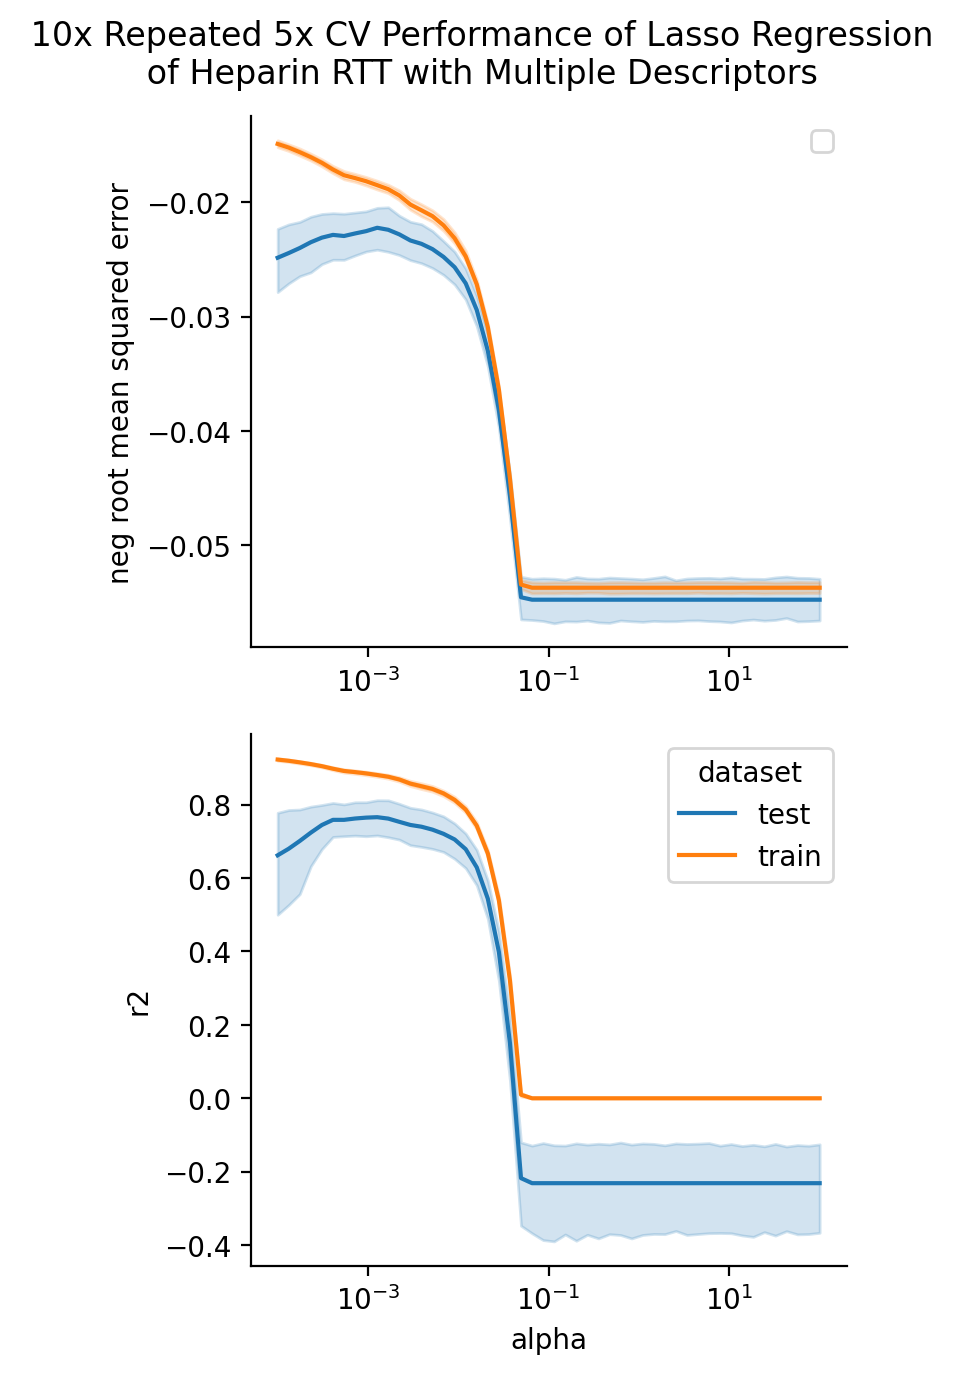

In [8]:

fig, axes = plt.subplots(2,1, figsize = (4,7))
axes = np.ravel( axes)
ax = sns.lineplot(data = lasso_search_results, x='param_lasso__alpha', y= 'neg_root_mean_squared_error', hue = 'dataset', ax =axes[0])
ax.set(xscale='log', xlabel = '',ylabel = 'neg_root_mean_squared_error'.replace('_', ' '))
ax.legend('')

ax = sns.lineplot(data = lasso_search_results, x='param_lasso__alpha', y= 'r2', hue = 'dataset', ax = axes[1])
ax.set(xscale='log', xlabel = 'alpha')
fig.suptitle(' 10x Repeated 5x CV Performance of Lasso Regression\n of Heparin RTT with Multiple Descriptors')
sns.despine()
fig.tight_layout()

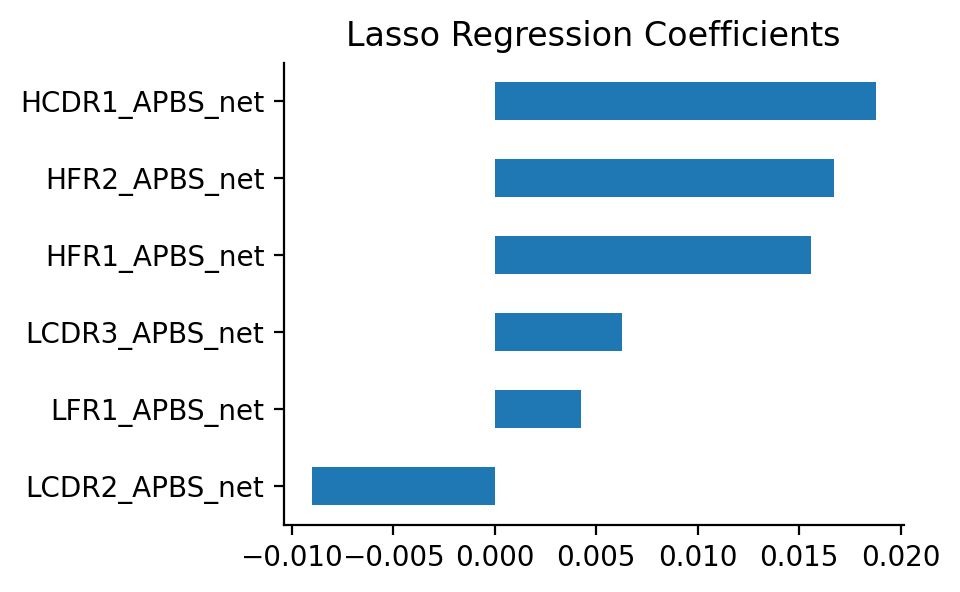

In [9]:
lasso_search.best_params_
estimator = lasso_search.best_estimator_
coefs = pd.Series(estimator.steps[1][1].coef_, index = X_train_net.columns)

ax = drop_zeros(coefs.sort_values()).plot(kind = 'barh', figsize = (4,3))
ax.set( title = 'Lasso Regression Coefficients')
sns.despine()


In [10]:
model_type = 'lasso'
model = Lasso()
param_grid = {'lasso__alpha':np.logspace(start =-4, stop = 2)}
lasso_performance_df, lasso_searches = fit_regression_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid)

  0%|          | 0/3 [00:00<?, ?it/s]

#### Fit the same datasets with Ridge Regression

In [22]:
ridges = {}

performances = []
model_type = 'ridge'
model = Ridge()
param_grid = {'ridge__alpha':np.logspace(start =-4, stop = 2)}
ridge_performance_df, ridge_searches = fit_regression_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid)


  0%|          | 0/3 [00:00<?, ?it/s]

### Fit with Elastic Net

In [23]:
elastic_nets = {}

model_type = 'elastic_net'
model = ElasticNet()
param_grid = {'elastic_net__alpha':np.logspace(start =-4, stop = 2), 'elastic_net__l1_ratio': np.linspace(0,1,5)}
elastic_net_performance_df, elastic_net_searches = fit_regression_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid)


  0%|          | 0/3 [00:00<?, ?it/s]

#### Fit with Random Forests

In [24]:
model_type = 'rf'
model = RandomForestRegressor(n_jobs=-1)
param_grid = {'rf__max_depth': [1,3, 5, 7, 9], 'rf__max_features': [2, 4, 'sqrt', 'log2'], 'rf__n_estimators':[50, 100, 200]}
rf_net_performance_df, rf_searches = fit_regression_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
regression_performance_df = pd.concat([lasso_performance_df, ridge_performance_df, elastic_net_performance_df, rf_net_performance_df])
round_numerical_columns(regression_performance_df.sort_values(['mean_test_RMSE', 'mean_test_r2'], ascending = [True, False]), decimals=4).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,mean_test_RMSE,std_test_RMSE,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,param_ridge__alpha,param_elastic_net__alpha,param_elastic_net__l1_ratio,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators
CDR_net_rf,0.1252,0.0079,0.0165,0.0016,NaN,"{'rf__max_depth': 9, 'rf__max_features': 'sqrt...",0.0201,0.0070,1,0.0078,0.0008,0.8006,0.1660,3,0.9788,0.0044,NaN,NaN,NaN,9,sqrt,200
CDR_FR_pos_elastic_net,0.0022,0.0001,0.0009,0.0001,NaN,"{'elastic_net__alpha': 0.021209508879201904, '...",0.0202,0.0056,1,0.0158,0.0011,0.8052,0.1546,1,0.9132,0.0131,NaN,0.02121,0.0,NaN,NaN,NaN
CDR_FR_pos_ridge,0.0012,0.0002,0.0009,0.0001,NaN,{'ridge__alpha': 1.0985411419875573},0.0202,0.0056,1,0.0159,0.0011,0.8053,0.1528,1,0.9119,0.0134,1.098541,NaN,NaN,NaN,NaN,NaN
CDR_FR_pos_rf,0.0664,0.0081,0.0149,0.0002,NaN,"{'rf__max_depth': 9, 'rf__max_features': 'log2...",0.0202,0.0066,1,0.0078,0.0009,0.8023,0.1522,5,0.9784,0.0050,NaN,NaN,NaN,9,log2,100
CDR_FR_net_rf,0.0712,0.0032,0.0174,0.0007,NaN,"{'rf__max_depth': 9, 'rf__max_features': 2, 'r...",0.0203,0.0067,1,0.0078,0.0009,0.8021,0.1516,1,0.9787,0.0047,NaN,NaN,NaN,9,2,100


#### Remarks for regression.
We can see that For the best models, in general they use CDR_FR_pos, i.e. charges from both regions. While the random forest does the best on RMSE, it is not really significantly significant. It also has more variance (not surprisingly). Furthermore it's test $r^2$ is slighly (not really significant) worse than the elastic net and ridge regression. 
I will go with the linear model for now.  CDR_FR_pos_elastic_net.

Save the models. 

In [140]:
def save_model(model, model_path, name):
    dump(model, model_path/f'{name}.joblib')

def load_model(model_path, name):
    return load(model_path/f'{name}.joblib')

def plot_feature_importances(model, n_features=10, ax = None, model_name=None):
    """ plot feature importances"""
    if hasattr(model[-1], 'feature_importances_'):
        importances = model[-1].feature_importances_
        title = 'Feature Importances'
    if hasattr(model[-1], 'coef_'):
        importances = model[-1].coef_
        shape = importances.shape
        if len(shape)==2:
            importances = importances[0]

        title = 'Coefficients'
    
    if model_name:
        title = f'{model_name} {title}'

    features = model[:-1].get_feature_names_out()
    s = (pd.Series( importances, index = features)
         .sort_values()
         .iloc[:n_features]
        )
    
    if ax: 
        ax = s.plot(kind = 'barh', ax = ax)
    else:
        ax =s.plot(kind = 'barh', figsize = (4,3))
    ax.set_title(title)
    sns.despine()
    return ax

In [27]:
base_model_path = data_path/'models'
if not base_model_path.exists():
    base_model_path.mkdir()

model_path = base_model_path/'models_for_11-07-2023_TrainingModelsNB2'
if not model_path.exists():
    model_path.mkdir()  

def save_model(model, model_path, name):
    dump(model, model_path/f'{name}.joblib')

for name, search in lasso_searches.items():
    save_model(search.best_estimator_, model_path, name)

for name, search in ridge_searches.items():
    save_model(search.best_estimator_, model_path, name)

for name, search in rf_searches.items():
    save_model(search.best_estimator_, model_path, name)

for name, search in elastic_net_searches.items():
    save_model(search.best_estimator_, model_path, name)


#### Look at the features for the elastic net model

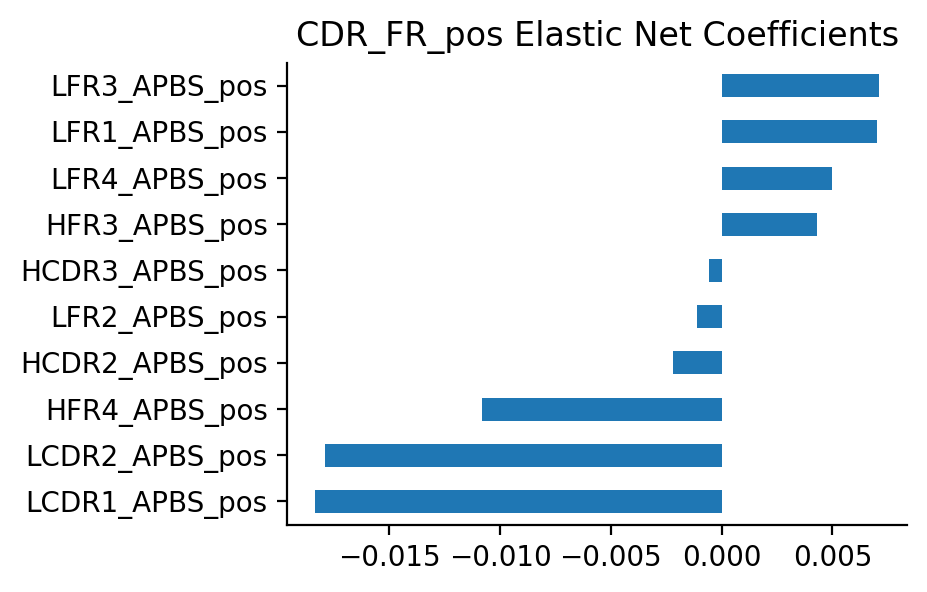

In [460]:
elastic_net =load_model(model_path, 'CDR_FR_pos_elastic_net')
plot_feature_importances(elastic_net, n_features=10, model_name='CDR_FR_pos Elastic Net');


#### Look at the features for the Random Forest Model 

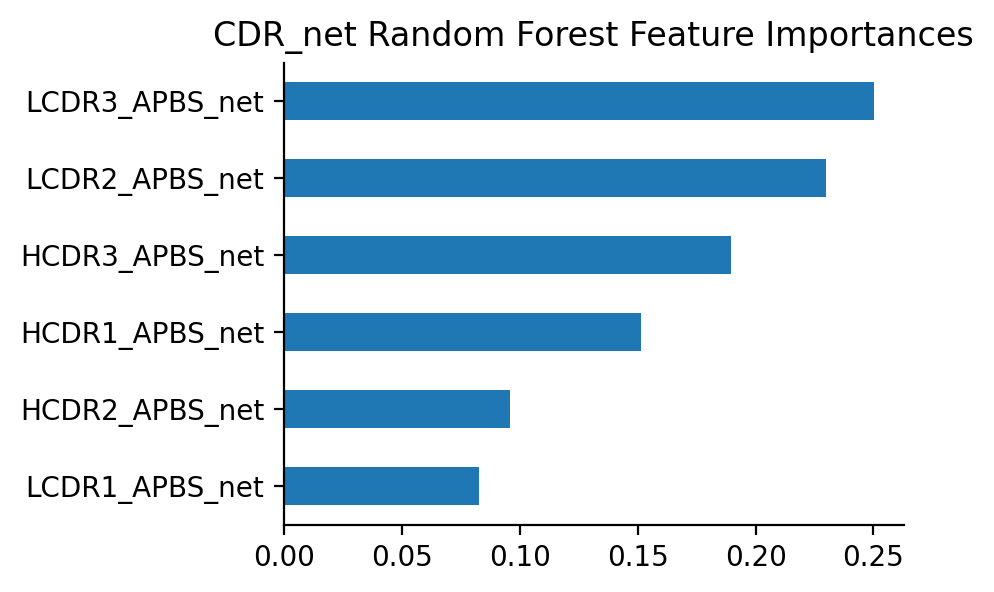

In [142]:
rf =load_model(model_path, 'CDR_net_rf')
plot_feature_importances(rf, n_features=10, model_name = 'CDR_net Random Forest');

### Now train some classifiers on the subset of data 

In [84]:

def fit_classifier_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid, charges = None, regions = None):
    if not charges: 
        charges = ['pos', 'neg', 'net']
    if not regions: 
        regions = [['CDR'], ['FR'], ['CDR', 'FR']]

    searches = {}
    performances = []
    metrics =  ['accuracy', 'recall', 'f1', 'roc_auc','precision']
    refit = 'roc_auc'

    for charge in tqdm(charges, total = 3):
        for region in regions: 
            cols = select_cols(X_train, charge=charge, regions=region, specifc_region=True)
            X_train_subset = X_train[cols].copy()

            pipes = Pipeline([('scaler', StandardScaler()), 
                        (model_type, model)])
            cv =  RepeatedKFold(random_state=42)

            search = GridSearchCV(pipes, param_grid = param_grid , cv = cv, refit =refit, return_train_score = True,scoring=metrics)
            search.fit(X_train_subset, y_train[['Label']])

            region_name = '_'.join(region)
            name = f'{region_name}_{charge}_{model_type}'

            searches[name] = search
            results = select_search_results_cols(search).sort_values('rank_test_roc_auc').head(1)
            results.index = [name]
            performances.append(results)

    performances_df = (convert_numerical_columns_to_absolute_values(pd.concat(performances))
                        .sort_values('mean_test_roc_auc', ascending = True)
                        )
    return performances_df, searches


In [85]:
model_type = 'logistic_l1'
model = LogisticRegression(penalty='l1', solver = 'liblinear')
param_grid = param_grid = {'logistic_l1__C':np.logspace(start =-4, stop = 2)}
logistic_l1_performance_df,logistic_l1_searches = fit_classifier_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid)


  0%|          | 0/3 [00:00<?, ?it/s]

In [87]:
logistic_l1_performance_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_l1__C,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision
FR_neg_logistic_l1,0.001129,0.000010,0.007297,0.000028,0.086851,{'logistic_l1__C': 0.08685113737513521},0.840000,0.114066,25,0.835417,0.041719,0.954976,0.100770,1,0.958087,0.021478,0.812165,0.149012,17,0.821681,0.050354,0.932752,0.098184,1,0.938366,0.019496,0.732587,0.202957,25,0.722239,0.073563
CDR_neg_logistic_l1,0.001121,0.000017,0.007313,0.000026,0.086851,{'logistic_l1__C': 0.08685113737513521},0.868333,0.081803,18,0.871250,0.036250,0.954976,0.100770,1,0.958087,0.021478,0.836819,0.116787,6,0.854638,0.045722,0.945242,0.106828,1,0.950845,0.020037,0.762738,0.164020,25,0.773797,0.067863
FR_pos_logistic_l1,0.001161,0.000038,0.007345,0.000181,1.456348,{'logistic_l1__C': 1.4563484775012443},0.883333,0.086603,9,0.921250,0.019225,0.888167,0.165663,12,0.934920,0.059762,0.843076,0.126781,12,0.904065,0.023891,0.952340,0.075573,1,0.967521,0.013003,0.841238,0.173835,2,0.881979,0.062690
CDR_FR_neg_logistic_l1,0.001701,0.000352,0.007367,0.000065,24.420531,{'logistic_l1__C': 24.420530945486497},0.841667,0.097539,22,0.944167,0.022989,0.787905,0.225057,22,0.949509,0.035910,0.769814,0.184947,22,0.931002,0.028798,0.952358,0.064280,1,0.990092,0.006520,0.800429,0.224018,17,0.914217,0.036690
FR_net_logistic_l1,0.001168,0.000022,0.007303,0.000038,2.559548,{'logistic_l1__C': 2.559547922699533},0.868333,0.088333,9,0.921667,0.021065,0.854619,0.211948,15,0.921557,0.072030,0.813006,0.172949,13,0.902656,0.030338,0.960700,0.067161,1,0.973572,0.009139,0.822024,0.213716,8,0.892638,0.063355
CDR_FR_pos_logistic_l1,0.001434,0.000107,0.007354,0.000034,13.894955,{'logistic_l1__C': 13.89495494373136},0.890000,0.091954,13,0.970000,0.013919,0.858833,0.201539,22,0.967832,0.029428,0.838926,0.179637,17,0.962725,0.017031,0.960748,0.065203,1,0.997987,0.001815,0.854595,0.213580,1,0.958833,0.028869
CDR_net_logistic_l1,0.002187,0.000613,0.007426,0.000097,100.0,{'logistic_l1__C': 100.0},0.873333,0.097525,26,0.946250,0.034382,0.826690,0.233636,26,0.938551,0.039598,0.806796,0.209897,27,0.933245,0.042506,0.963463,0.053065,1,0.993658,0.004279,0.814429,0.229846,26,0.928861,0.053101
CDR_pos_logistic_l1,0.002302,0.000685,0.007396,0.000099,75.431201,{'logistic_l1__C': 75.43120063354607},0.866667,0.076376,27,0.964167,0.022454,0.826976,0.222081,27,0.958883,0.028443,0.798880,0.194378,27,0.955829,0.026740,0.966245,0.044292,1,0.996035,0.003075,0.800214,0.222360,25,0.953795,0.039374
CDR_FR_net_logistic_l1,0.001775,0.000260,0.007428,0.000156,32.374575,{'logistic_l1__C': 32.3745754281764},0.871667,0.090077,23,0.992500,0.010000,0.838286,0.201703,26,0.988842,0.022455,0.815913,0.173744,23,0.990494,0.012860,0.967005,0.050844,1,1.000000,0.000000,0.831333,0.211784,9,0.992644,0.016921


In [89]:
model_type = 'logistic_l2'
model = LogisticRegression(penalty='l2', solver = 'liblinear')
param_grid = param_grid = {'logistic_l2__C':np.logspace(start =-4, stop = 2)}
logistic_l2_performance_df,logistic_l2_searches = fit_classifier_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid)


  0%|          | 0/3 [00:00<?, ?it/s]

In [90]:
model_type = 'logistic_elasticnet'
model = LogisticRegression(penalty='elasticnet', solver = 'saga')
param_grid = param_grid = {'logistic_elasticnet__C':np.logspace(start =-4, stop = 2), 'logistic_elasticnet__l1_ratio':np.linspace(0,1,5)}
logistic_elasticnet_performance_df,logistic_elasticnet_searches = fit_classifier_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid)


  0%|          | 0/3 [00:00<?, ?it/s]

In [94]:
model_type = 'rf_classifier'
model = RandomForestClassifier(n_jobs=-1)
param_grid = {'rf_classifier__max_depth': [1,3, 5, 7, 9], 'rf_classifier__max_features': [2, 4, 'sqrt', 'log2'], 'rf_classifier__n_estimators':[50, 100, 200]}
rf_classifier_performance_df, rf_classifier_searches = fit_classifier_models_on_feature_subsets(X_train, y_train, model_type, model, param_grid).head()

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [96]:
classification_performance_df = pd.concat([logistic_l1_performance_df, logistic_l2_performance_df, logistic_elasticnet_performance_df, rf_classifier_performance_df])
round_numerical_columns(classification_performance_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending = [False, False]), decimals=4).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_l1__C,params,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,param_logistic_l2__C,param_logistic_elasticnet__C,param_logistic_elasticnet__l1_ratio,param_rf_classifier__max_depth,param_rf_classifier__max_features,param_rf_classifier__n_estimators
CDR_FR_net_logistic_l1,0.0018,0.0003,0.0074,0.0002,32.374575,{'logistic_l1__C': 32.3745754281764},0.8717,0.0901,23,0.9925,0.0100,0.8383,0.2017,26,0.9888,0.0225,0.8159,0.1737,23,0.9905,0.0129,0.9670,0.0508,1,1.0000,0.0000,0.8313,0.2118,9,0.9926,0.0169,NaN,NaN,NaN,NaN,NaN,NaN
CDR_pos_logistic_l1,0.0023,0.0007,0.0074,0.0001,75.431201,{'logistic_l1__C': 75.43120063354607},0.8667,0.0764,27,0.9642,0.0225,0.8270,0.2221,27,0.9589,0.0284,0.7989,0.1944,27,0.9558,0.0267,0.9662,0.0443,1,0.9960,0.0031,0.8002,0.2224,25,0.9538,0.0394,NaN,NaN,NaN,NaN,NaN,NaN
CDR_net_logistic_l1,0.0022,0.0006,0.0074,0.0001,100.0,{'logistic_l1__C': 100.0},0.8733,0.0975,26,0.9462,0.0344,0.8267,0.2336,26,0.9386,0.0396,0.8068,0.2099,27,0.9332,0.0425,0.9635,0.0531,1,0.9937,0.0043,0.8144,0.2298,26,0.9289,0.0531,NaN,NaN,NaN,NaN,NaN,NaN
CDR_FR_net_logistic_l2,0.0012,0.0000,0.0074,0.0001,NaN,{'logistic_l2__C': 56.89866029018293},0.8717,0.0853,49,0.9675,0.0151,0.8458,0.1959,49,0.9653,0.0360,0.8140,0.1747,50,0.9592,0.0197,0.9632,0.0588,1,0.9973,0.0017,0.8179,0.2164,48,0.9545,0.0288,56.89866,NaN,NaN,NaN,NaN,NaN
CDR_FR_pos_logistic_l1,0.0014,0.0001,0.0074,0.0000,13.894955,{'logistic_l1__C': 13.89495494373136},0.8900,0.0920,13,0.9700,0.0139,0.8588,0.2015,22,0.9678,0.0294,0.8389,0.1796,17,0.9627,0.0170,0.9607,0.0652,1,0.9980,0.0018,0.8546,0.2136,1,0.9588,0.0289,NaN,NaN,NaN,NaN,NaN,NaN


##### save models 

In [97]:
for name, search in logistic_l1_searches.items():
    save_model(search.best_estimator_, model_path, name)

for name, search in logistic_l2_searches.items():
    save_model(search.best_estimator_, model_path, name)

for name, search in logistic_elasticnet_searches.items():
    save_model(search.best_estimator_, model_path, name)

for name, search in rf_classifier_searches.items():
    save_model(search.best_estimator_, model_path, name)

logistic_l1 = load_model(model_path, 'CDR_FR_net_logistic_l1')

##### save the results 

In [103]:
regression_performance_df['param_rf__max_features']=regression_performance_df['param_rf__max_features'].astype(str)
regression_performance_df['params']=regression_performance_df['params'].astype(str)
regression_performance_df.to_parquet(model_path/'regression_performance.pq')


In [105]:
classification_performance_df['param_rf_classifier__max_features']=classification_performance_df['param_rf_classifier__max_features'].astype(str)
classification_performance_df['params']=classification_performance_df['params'].astype(str)
classification_performance_df.to_parquet(model_path/'classification_performance.pq')

### Look at results in more detail.

In [122]:
def show_test_cols(df, decimals = 4):
    """ select test columns"""
    cols = [col for col in df.columns if 'test' in col and 'rank' not in col]   
    return round_numerical_columns(df[cols], decimals=decimals)
    

#### Regression Performance

In [461]:
regression_test = show_test_cols(regression_performance_df, 4).sort_values(['mean_test_RMSE', 'mean_test_r2'], ascending = [True, False])
regression_test.head(15)

,mean_test_RMSE,std_test_RMSE,mean_test_r2,std_test_r2
CDR_net_rf,0.0201,0.0070,0.8006,0.1660
CDR_FR_pos_ridge,0.0202,0.0056,0.8053,0.1528
CDR_FR_pos_elastic_net,0.0202,0.0056,0.8052,0.1546
CDR_FR_pos_rf,0.0202,0.0066,0.8023,0.1522
CDR_FR_net_rf,0.0203,0.0067,0.8021,0.1516
CDR_FR_pos_lasso,0.0205,0.0066,0.8006,0.1502
FR_pos_rf,0.0205,0.0065,0.7994,0.1459
CDR_pos_rf,0.0205,0.0066,0.7979,0.1614
FR_net_rf,0.0210,0.0067,0.7883,0.1553
CDR_FR_neg_rf,0.0213,0.0069,0.7835,0.1641


In [139]:
px.scatter(regression_test.reset_index(), x='mean_test_RMSE', y='mean_test_r2', hover_name = 'index', title = 'Regression Performance', width = 500, height = 400)


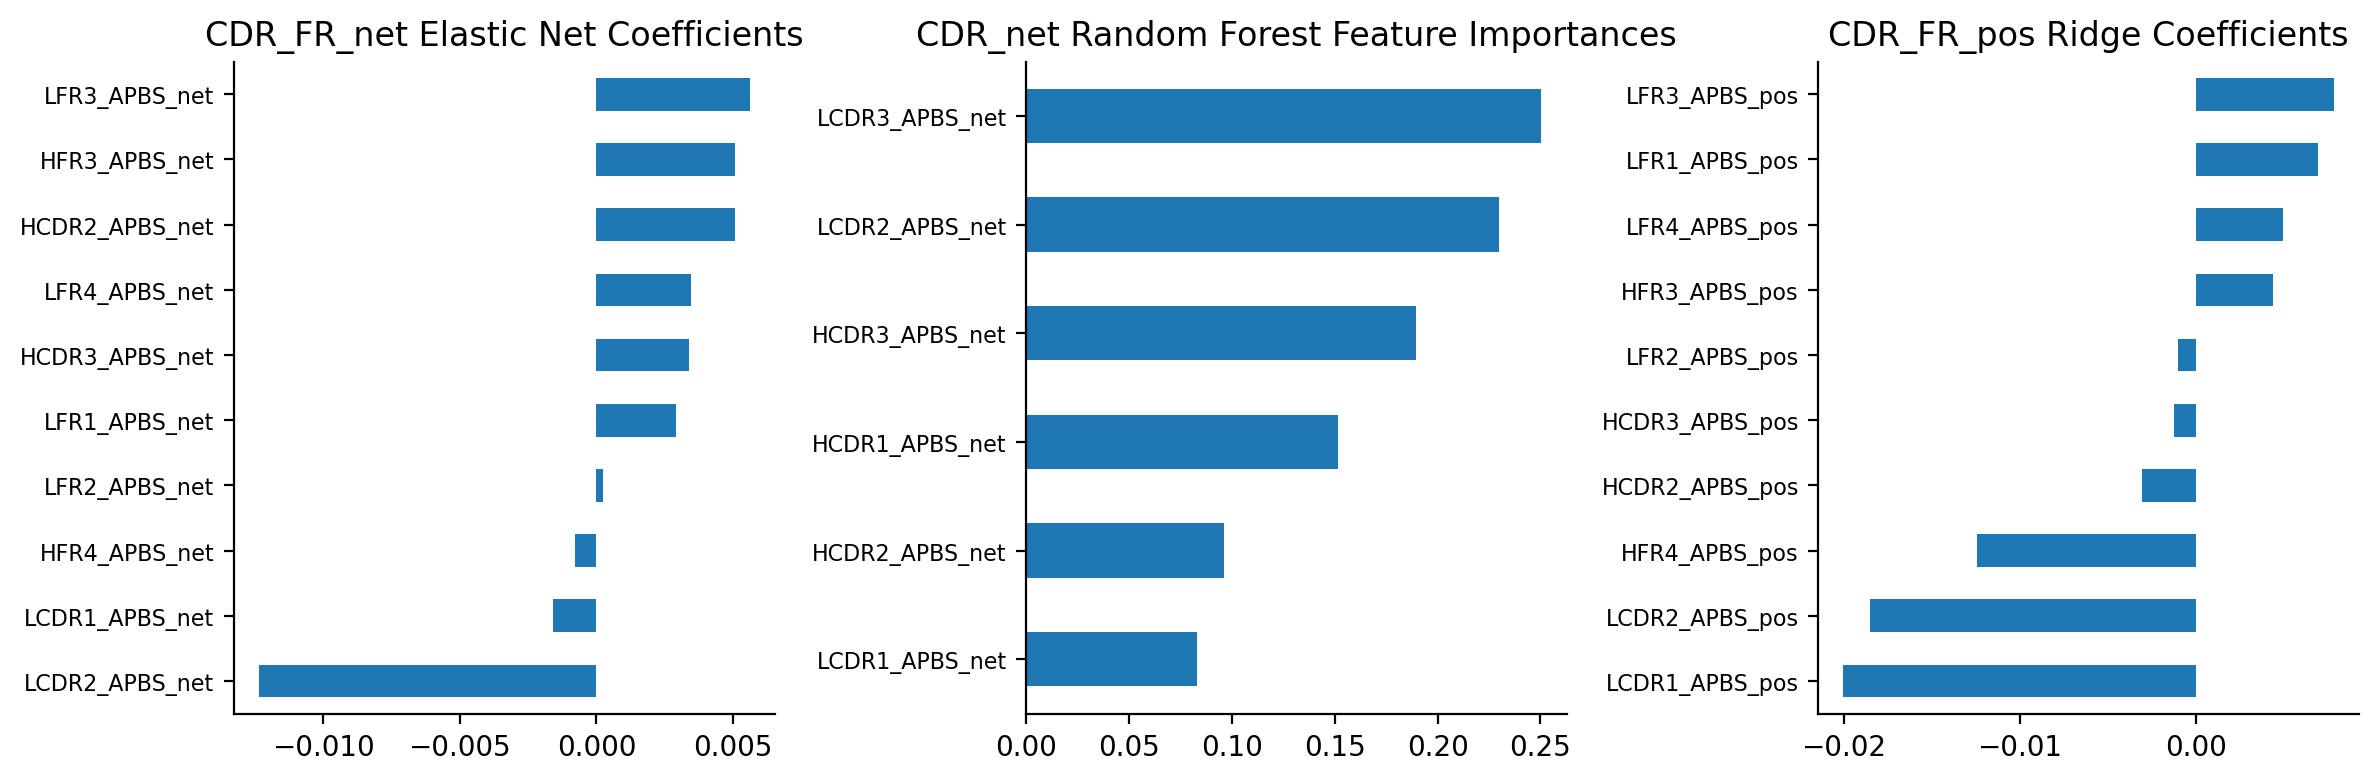

In [166]:
fig, axes = plt.subplots(1,3, figsize = (12,4))

elastic_net =load_model(model_path, 'CDR_FR_net_elastic_net')
ax = plot_feature_importances(elastic_net, n_features=10, model_name='CDR_FR_net Elastic Net', ax=axes[0])
ax.set_yticklabels(size = 8, labels = ax.get_yticklabels())

rf =load_model(model_path, 'CDR_net_rf')
ax=plot_feature_importances(rf, n_features=10, model_name = 'CDR_net Random Forest', ax=axes[1])
ax.set_yticklabels(size = 8, labels = ax.get_yticklabels())

ridge =load_model(model_path, 'CDR_FR_pos_ridge')
ax=plot_feature_importances(ridge, n_features=10, model_name = 'CDR_FR_pos Ridge', ax=axes[2])
ax.set_yticklabels(size = 8, labels = ax.get_yticklabels())

plt.tight_layout();

#### Remarks
These are pretty good candidates, For now I will choose the top ranked. The CDR_FR_net ElasticNet model. It has the best RMSE and its R2 on test is good. 



#### Classification Performance

In [170]:
classification_test= show_test_cols(classification_performance_df, 4).sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending = [False, False])
classification_test.head(10)

,mean_test_accuracy,std_test_accuracy,mean_test_recall,std_test_recall,mean_test_f1,std_test_f1,mean_test_roc_auc,std_test_roc_auc,mean_test_precision,std_test_precision
CDR_FR_net_logistic_l1,0.8717,0.0901,0.8383,0.2017,0.8159,0.1737,0.9670,0.0508,0.8313,0.2118
CDR_pos_logistic_l1,0.8667,0.0764,0.8270,0.2221,0.7989,0.1944,0.9662,0.0443,0.8002,0.2224
CDR_net_logistic_l1,0.8733,0.0975,0.8267,0.2336,0.8068,0.2099,0.9635,0.0531,0.8144,0.2298
CDR_FR_net_logistic_l2,0.8717,0.0853,0.8458,0.1959,0.8140,0.1747,0.9632,0.0588,0.8179,0.2164
CDR_FR_pos_logistic_l1,0.8900,0.0920,0.8588,0.2015,0.8389,0.1796,0.9607,0.0652,0.8546,0.2136
FR_net_logistic_l1,0.8683,0.0883,0.8546,0.2119,0.8130,0.1729,0.9607,0.0672,0.8220,0.2137
CDR_pos_logistic_l2,0.8817,0.0851,0.8453,0.2004,0.8262,0.1735,0.9592,0.0690,0.8424,0.2106
CDR_net_logistic_l2,0.8883,0.0937,0.8255,0.1989,0.8328,0.1862,0.9582,0.0638,0.8631,0.2102
CDR_FR_pos_logistic_l2,0.8900,0.0857,0.8822,0.1936,0.8395,0.1757,0.9578,0.0729,0.8342,0.2177
FR_pos_rf_classifier,0.8867,0.0968,0.8318,0.2328,0.8289,0.2049,0.9574,0.0646,0.8598,0.2286


In [178]:


p1 = px.scatter(classification_test.reset_index(), x='mean_test_roc_auc', y='mean_test_accuracy', hover_name = 'index', title = 'Classification Performance', width = 500, height = 400)
p2 = px.scatter(classification_test.reset_index(), x='mean_test_roc_auc', y='mean_test_f1', hover_name = 'index', title = 'Classification Performance', width = 500, height = 400)
p1


In [179]:
p2

CDR_FR_net_logistic_l1
CDR_pos_logistic_l1
CDR_net_logistic_l1
CDR_FR_net_logistic_l2
CDR_FR_pos_logistic_l1
FR_net_logistic_l1
CDR_pos_logistic_l2
CDR_net_logistic_l2
CDR_FR_pos_logistic_l2


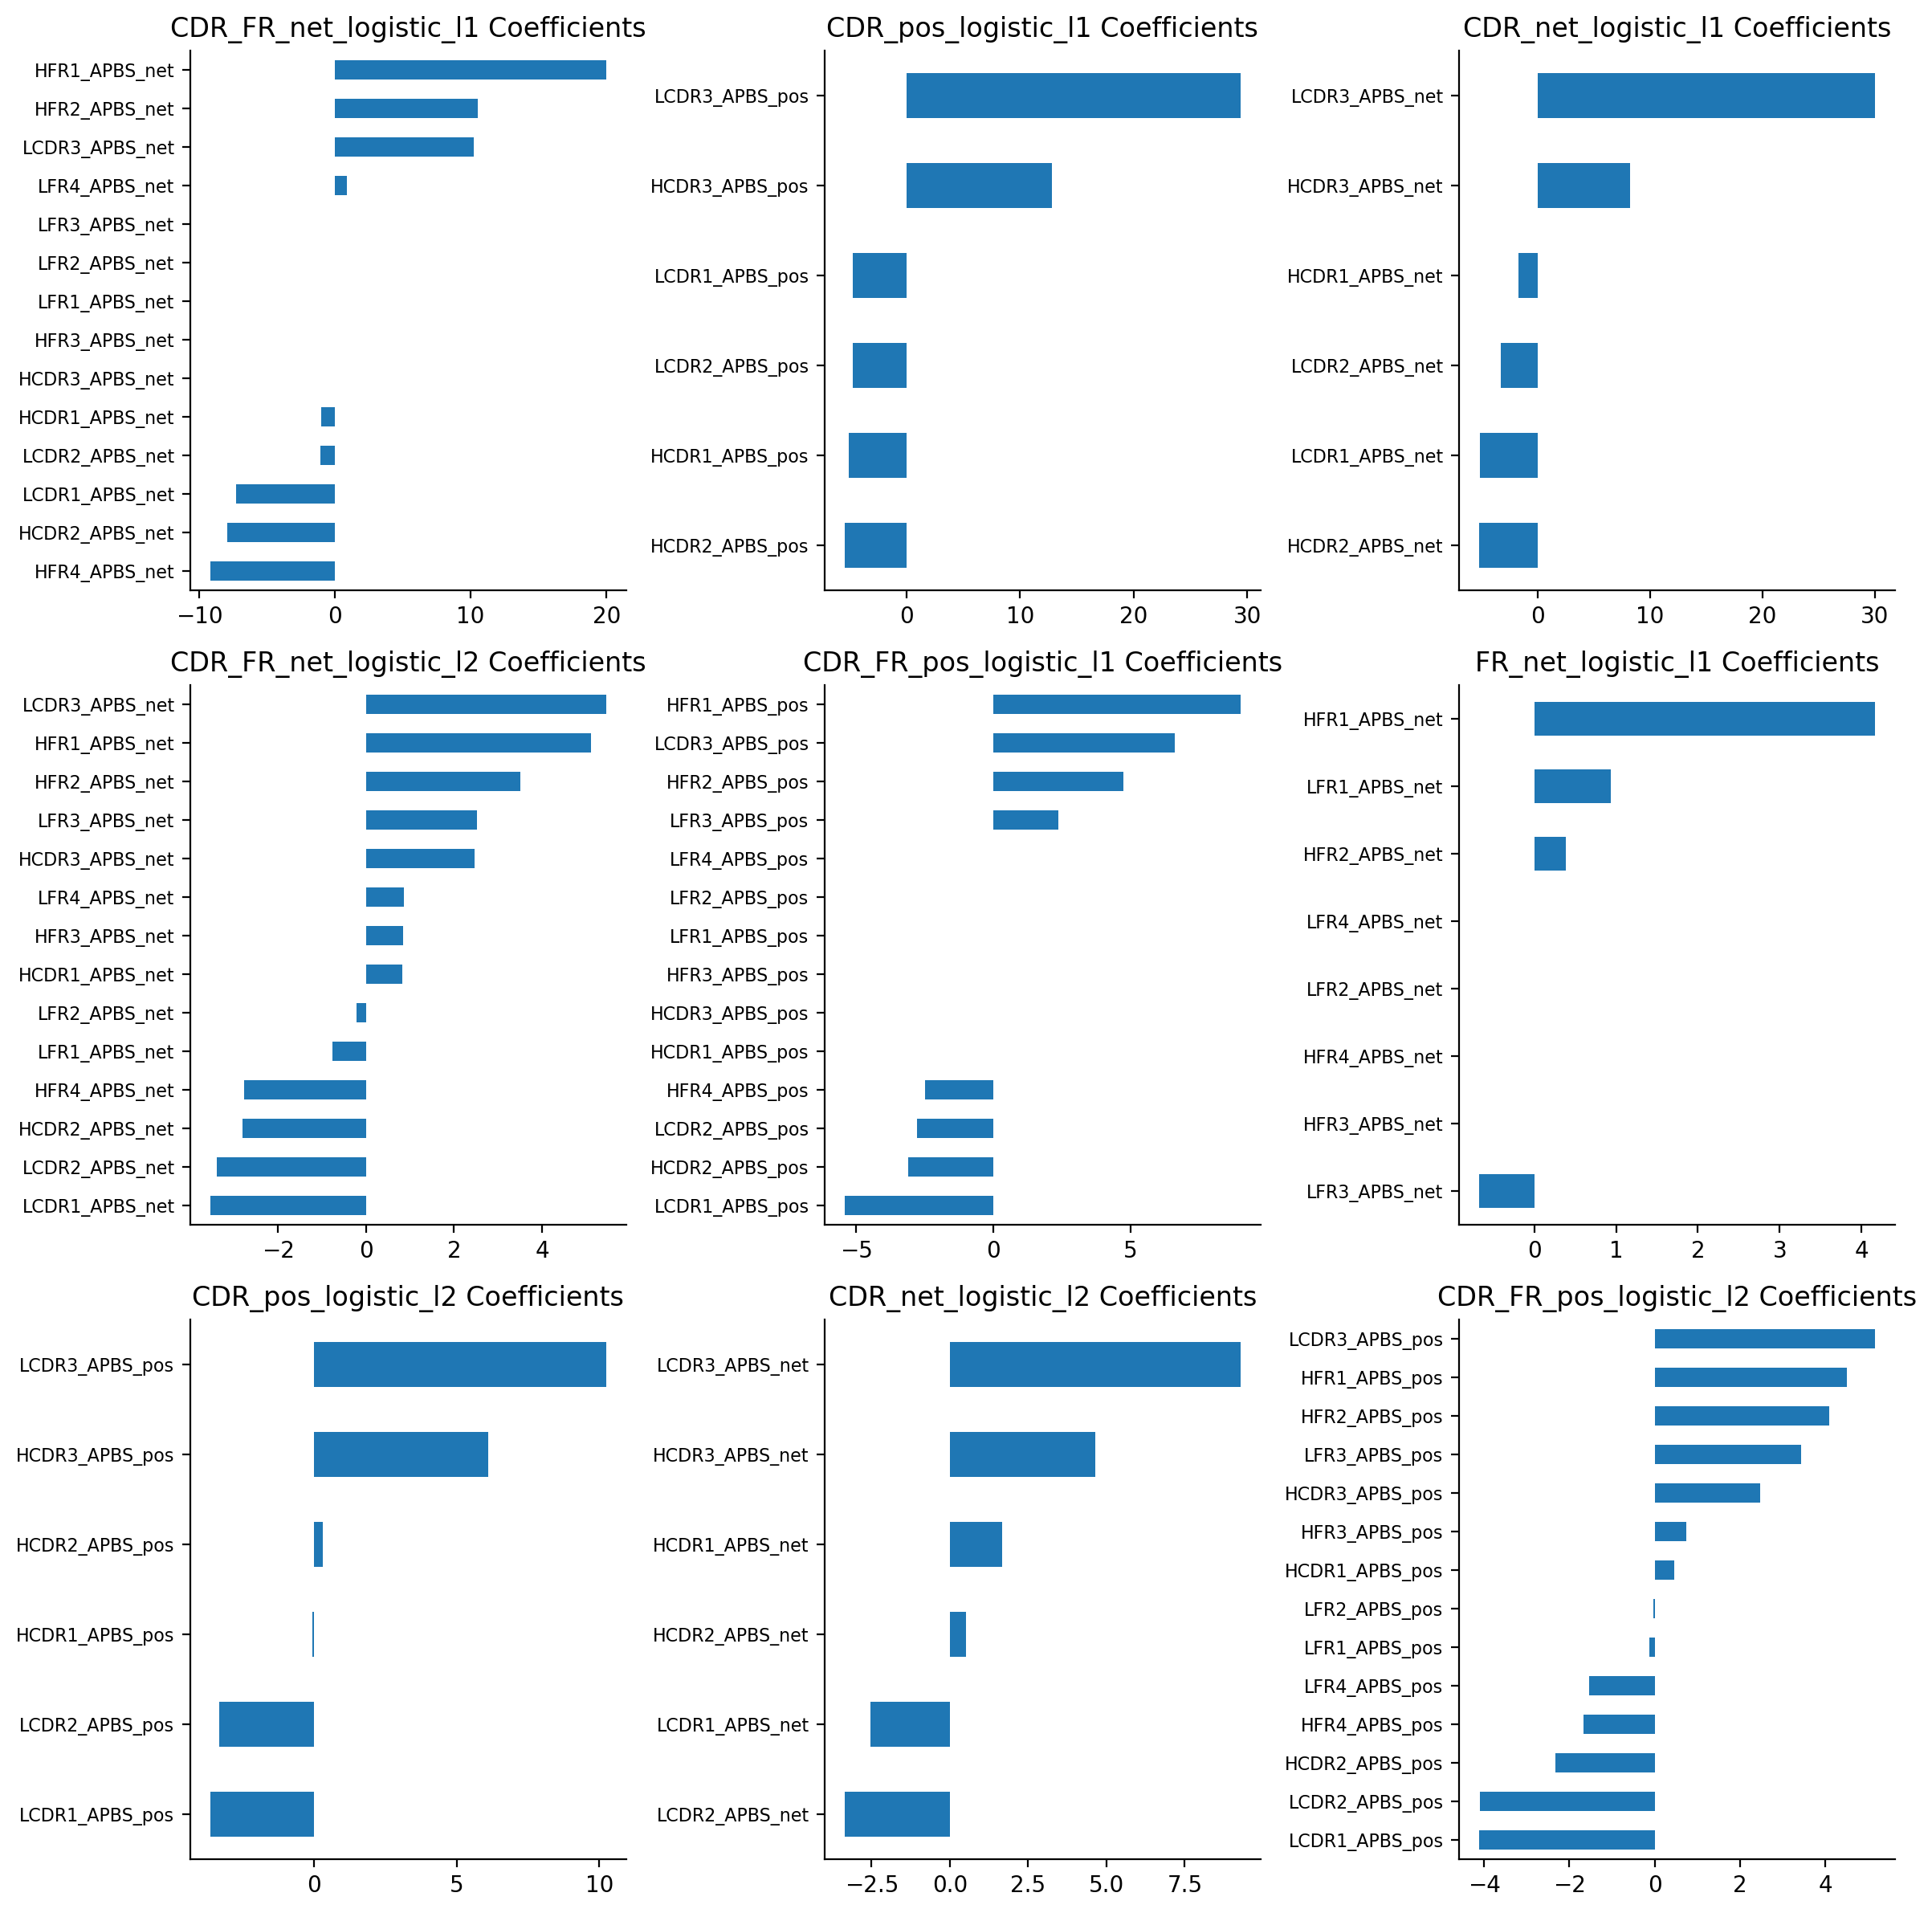

In [480]:
fig, axes = plt.subplots(3,3, figsize = (12,12))
axes = np.ravel(axes)
for i, model in enumerate(classification_test.index[:9]): 
    
    m =load_model(model_path, model)
    print(model)
    ax = plot_feature_importances(m, n_features=100, model_name = model, ax=axes[i])
    ax.set_yticklabels(size = 8, labels = ax.get_yticklabels())

plt.tight_layout();
    


#### Remarks: 
Despite being the fourth best performing model on AUC ROC, I am choosing the CDR_FR_net_ logistic L2 because it uses all of the features and it has good overall performance. 

### Save the searches as well. 

In [187]:
search_path = model_path/'grid_searches'
if not search_path.exists(): 
    search_path.mkdir()

for name, search in lasso_searches.items():
    save_model(search, search_path, name)

for name, search in ridge_searches.items():
    save_model(search, search_path, name)

for name, search in rf_searches.items():
    save_model(search, search_path, name)

for name, search in elastic_net_searches.items():
    save_model(search, search_path, name)


for name, search in logistic_l1_searches.items():
    save_model(search, search_path, name)

for name, search in logistic_l2_searches.items():
    save_model(search, search_path, name)

for name, search in logistic_elasticnet_searches.items():
    save_model(search, search_path, name)

for name, search in rf_classifier_searches.items():
    save_model(search, search_path, name)

### Additional plots for describing the performances. 
#### Some plots to show peformance 
I make the plots below to show to others. 

In [466]:
from sklearn.model_selection import   cross_validate, cross_val_predict, KFold, StratifiedKFold
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

def plot_cross_validation_performance(estimator, X_train, y_train,model_name=None):
    """ Plots an estimate showing the model performance"""
    
    cv =  KFold(n_splits = 5)
    y_pred = cross_val_predict(estimator, X_train,y_train, cv = cv, n_jobs = -1 )
    residuals = np.reshape(y_train.values, (-1,))-y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    ax = sns.regplot(x=y_pred, y=y_train, ax = axes[0])
    ax.set(title ='Actual vs Predicted Values', ylabel = 'Actual values', xlabel = 'Predicted values')
    ax = sns.regplot(x=y_pred, y=residuals, ax = axes[1])
    ax.set(title ='Residuals versus Predicted Values', ylabel = 'Residuals (actual - predicted)', xlabel = 'Predicted values')

   
    if model_name: 
        title = f'Cross Validation prediction for model {model_name}'
        fig.suptitle(title)

    plt.tight_layout()
    sns.despine()

    return fig, axes


def plot_cross_validation_classification_performance(classifier, X, y, model_name=None,label_name ='', n_splits = 5): 
    """plots roc curve. 
    This was adapted from SKlearn example:
    @https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    
    """
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cv =StratifiedKFold(n_splits = n_splits)
    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train, :], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test, :],
             y.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability for {model_name}\n(Positive label {label_name}')",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    sns.despine()
    return fig, ax



#### Plots for the regression model

/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.945e-03, tolerance: 1.516e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.596e-03, tolerance: 1.351e-05 Linear regression models with null weight for the l1 regularization term are more ef

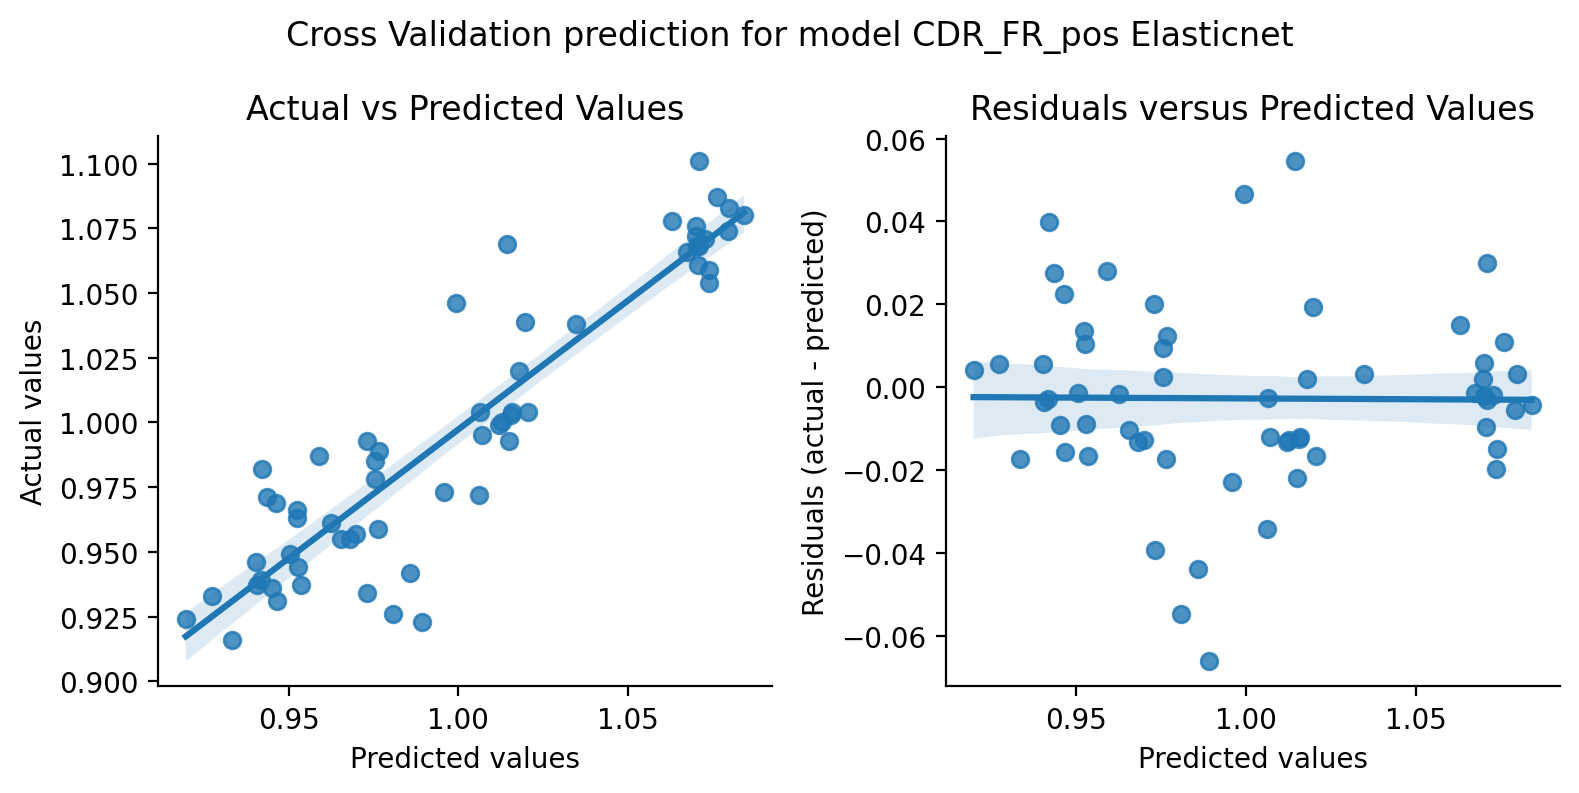

In [468]:
elastic_net = load_model(model_path, 'CDR_FR_pos_elastic_net')
plot_cross_validation_performance(elastic_net,X_train, y_train[['Hep RTT']], model_name ='CDR_FR_pos Elasticnet');

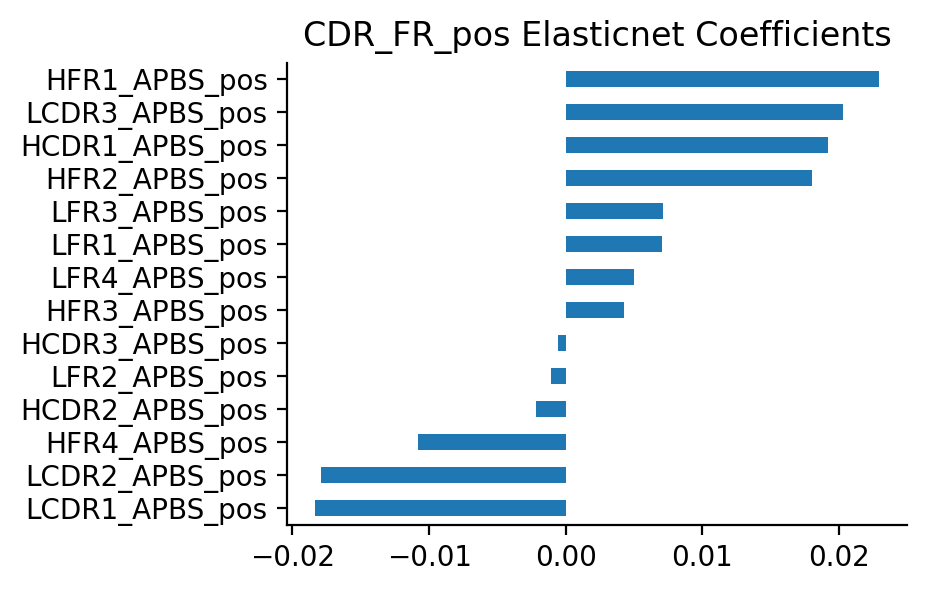

In [472]:
plot_feature_importances(elastic_net, n_features=100, model_name='CDR_FR_pos Elasticnet');

#### Classification

In [482]:
classification_test.index[3]

'CDR_FR_net_logistic_l2'

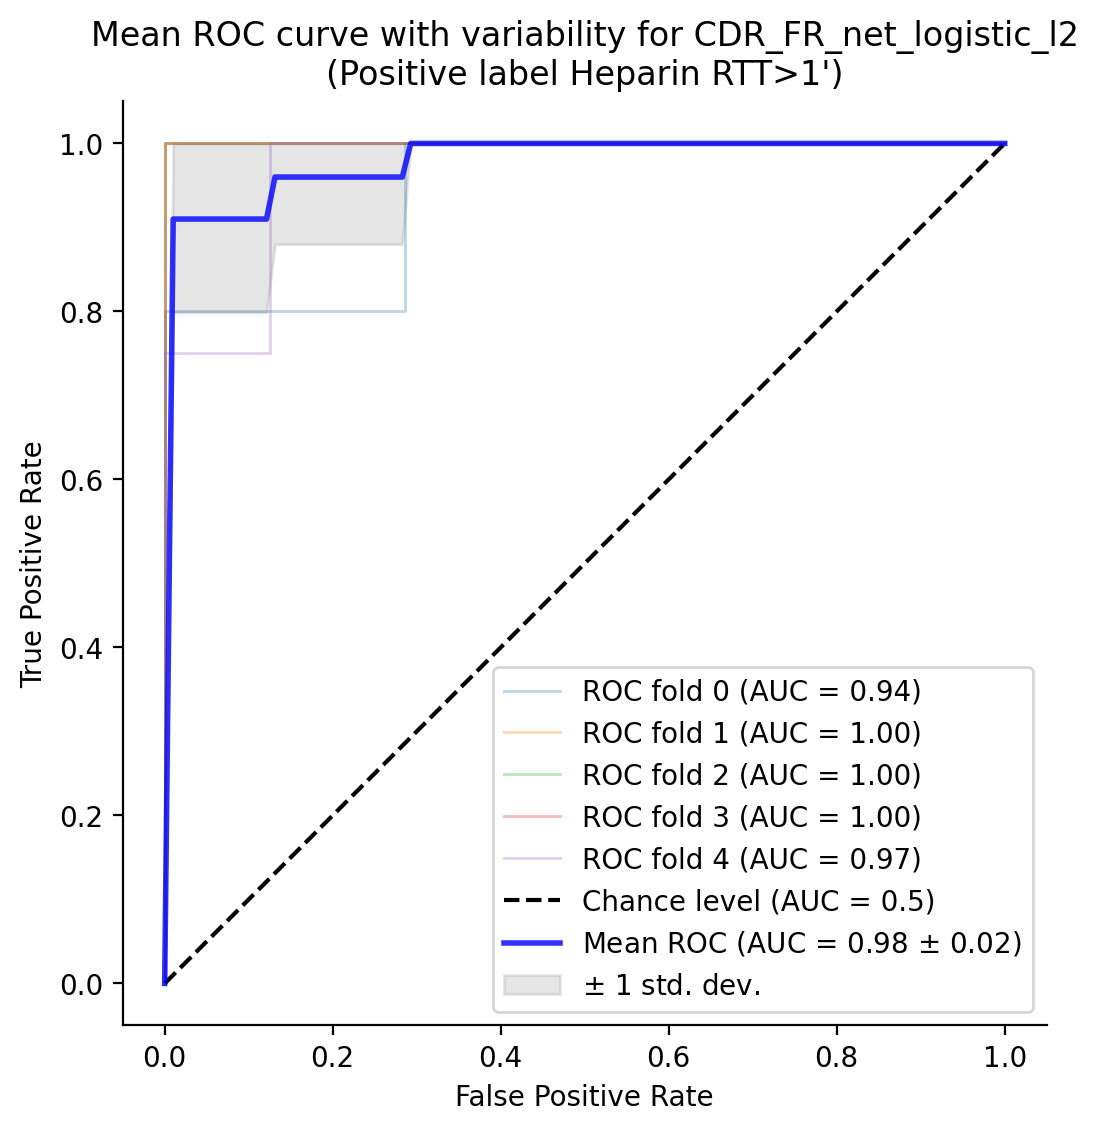

In [485]:
model_name = classification_test.index[3]
classifier = load_model(model_path,model_name )
plot_cross_validation_classification_performance(classifier, X_train, y_train['Label'],model_name, label_name='Heparin RTT>1');

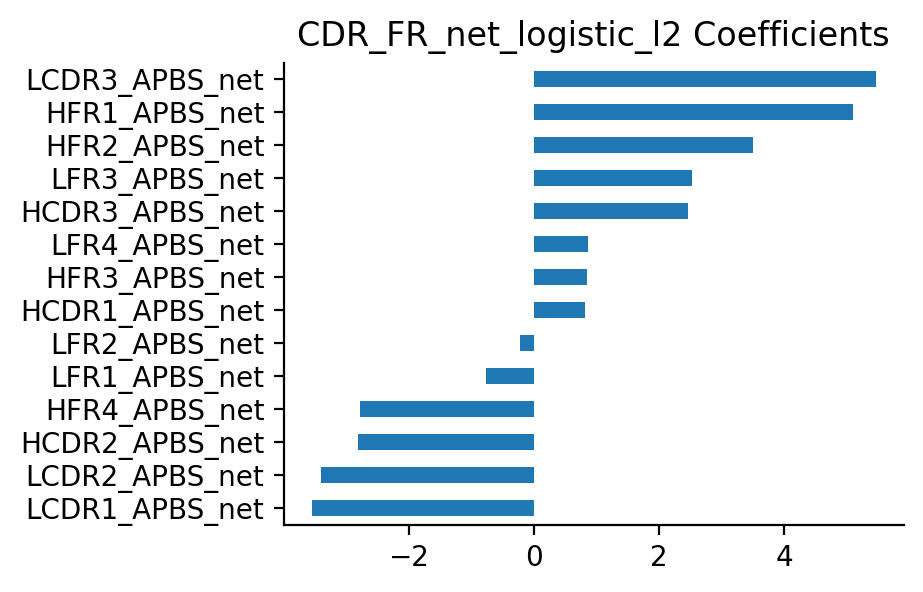

In [486]:
classifier = load_model(model_path,model_name )
plot_feature_importances(classifier, n_features=100, model_name=model_name);

### Plot regression peformance for RMSE and R2

In [389]:
regression_cv_results=[]

for search_dict  in [lasso_searches,ridge_searches, elastic_net_searches, rf_searches]:
    for name, search in search_dict.items():
        df = pd.DataFrame(search.cv_results_).sort_values('rank_test_neg_root_mean_squared_error').head(1)
        param = [col for col in df.columns if 'param_' in col][0]
        df =organize_search_results(df, param)
        df.index = [name]*len(df)
        regression_cv_results.append(df)

regression_cv_results_df = (pd.concat(regression_cv_results)
                            .query('dataset=="test"')
                            .reset_index()
                            .drop('dataset', axis = 1)
                            .rename({'index': 'model'}, axis = 1)
                            )
        

def extract_feature_set(model_name):
    """ extract feature set from model name"""
    return (model_name.replace('_ridge','')
            .replace('_lasso','')
            .replace('_rf', '')
            .replace('elastic_net','')
            .replace('_', ' ')
            )


regression_cv_results_df['RMSE'] = regression_cv_results_df['neg_root_mean_squared_error'].abs()
regression_cv_results_df['Feature Set'] = regression_cv_results_df['model'].apply(extract_feature_set)
        

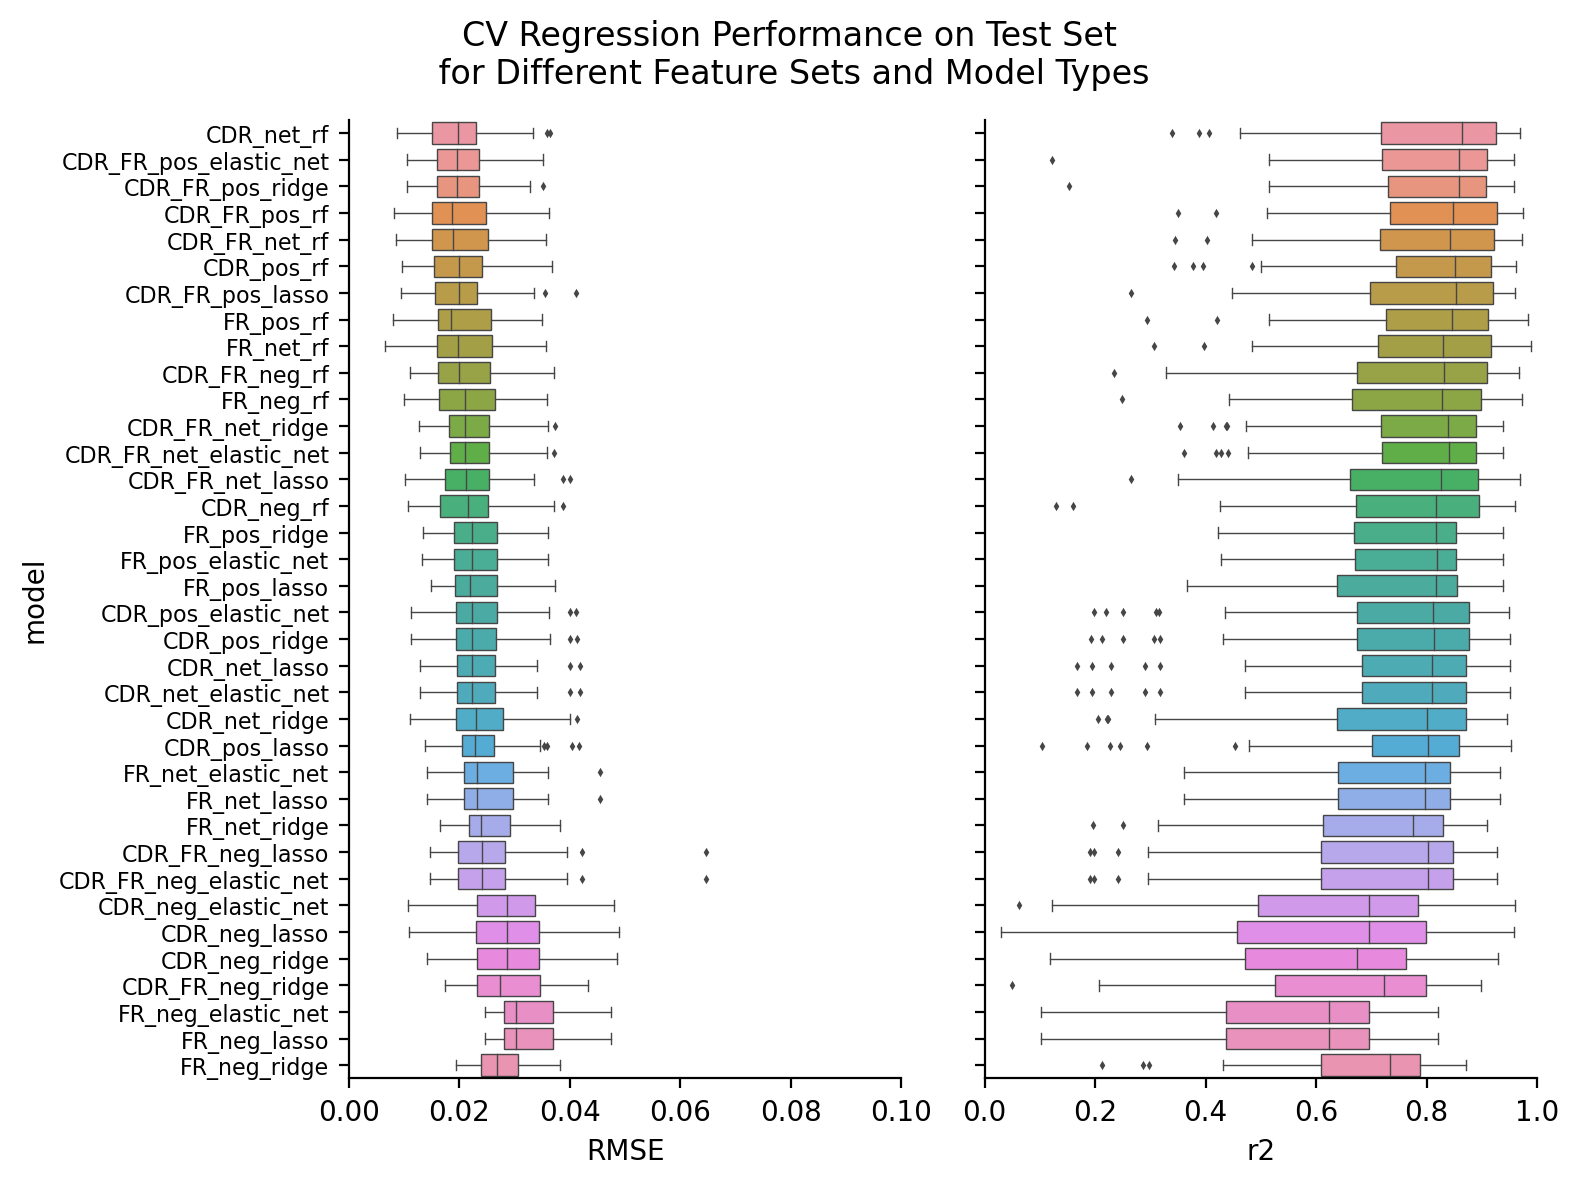

In [396]:
fig, axes = plt.subplots(1,2, figsize = (8,6))
order = regression_cv_results_df.groupby('model')['RMSE'].mean().sort_values().index
ax = sns.boxplot(data=regression_cv_results_df, y='model', x='RMSE', order = order, 
                  linewidth = 0.5, fliersize=1, ax = axes[0])
ax.set_yticklabels(size = 8, labels = ax.get_yticklabels())
ax.set_xlim(0, 0.1)

ax= sns.boxplot(data=regression_cv_results_df, y='model', x='r2', order = order, 
                  linewidth = 0.5, fliersize=1, ax = axes[1])
ax.set_xlim(0, 1)
ax.set(yticklabels="", ylabel = '')

fig.suptitle('CV Regression Performance on Test Set\n for Different Feature Sets and Model Types')

sns.despine()
plt.tight_layout()

In [449]:
regression_cv_results_df.groupby('model')['RMSE'].mean().sort_values().head()

model
CDR_net_rf                0.020130
CDR_FR_pos_elastic_net    0.020158
CDR_FR_pos_ridge          0.020161
CDR_FR_pos_rf             0.020190
CDR_FR_net_rf             0.020268
Name: RMSE, dtype: float64

### Classification CV Results

In [401]:
classification_cv_results=[]
for search_dict  in [logistic_l1_searches, logistic_l2_searches, logistic_elasticnet_searches, rf_classifier_searches]:
    for name, search in search_dict.items():
        df = pd.DataFrame(search.cv_results_).sort_values('rank_test_roc_auc').head(1)
        param = [col for col in df.columns if 'param_' in col][0]
        df =organize_search_results(df, param)
        df.index = [name]*len(df)
        classification_cv_results.append(df)

classification_cv_results_df =  (pd.concat(classification_cv_results)
                            .query('dataset=="test"')
                            .reset_index()
                            .drop('dataset', axis = 1)
                            .rename({'index': 'model'}, axis = 1)
                            )

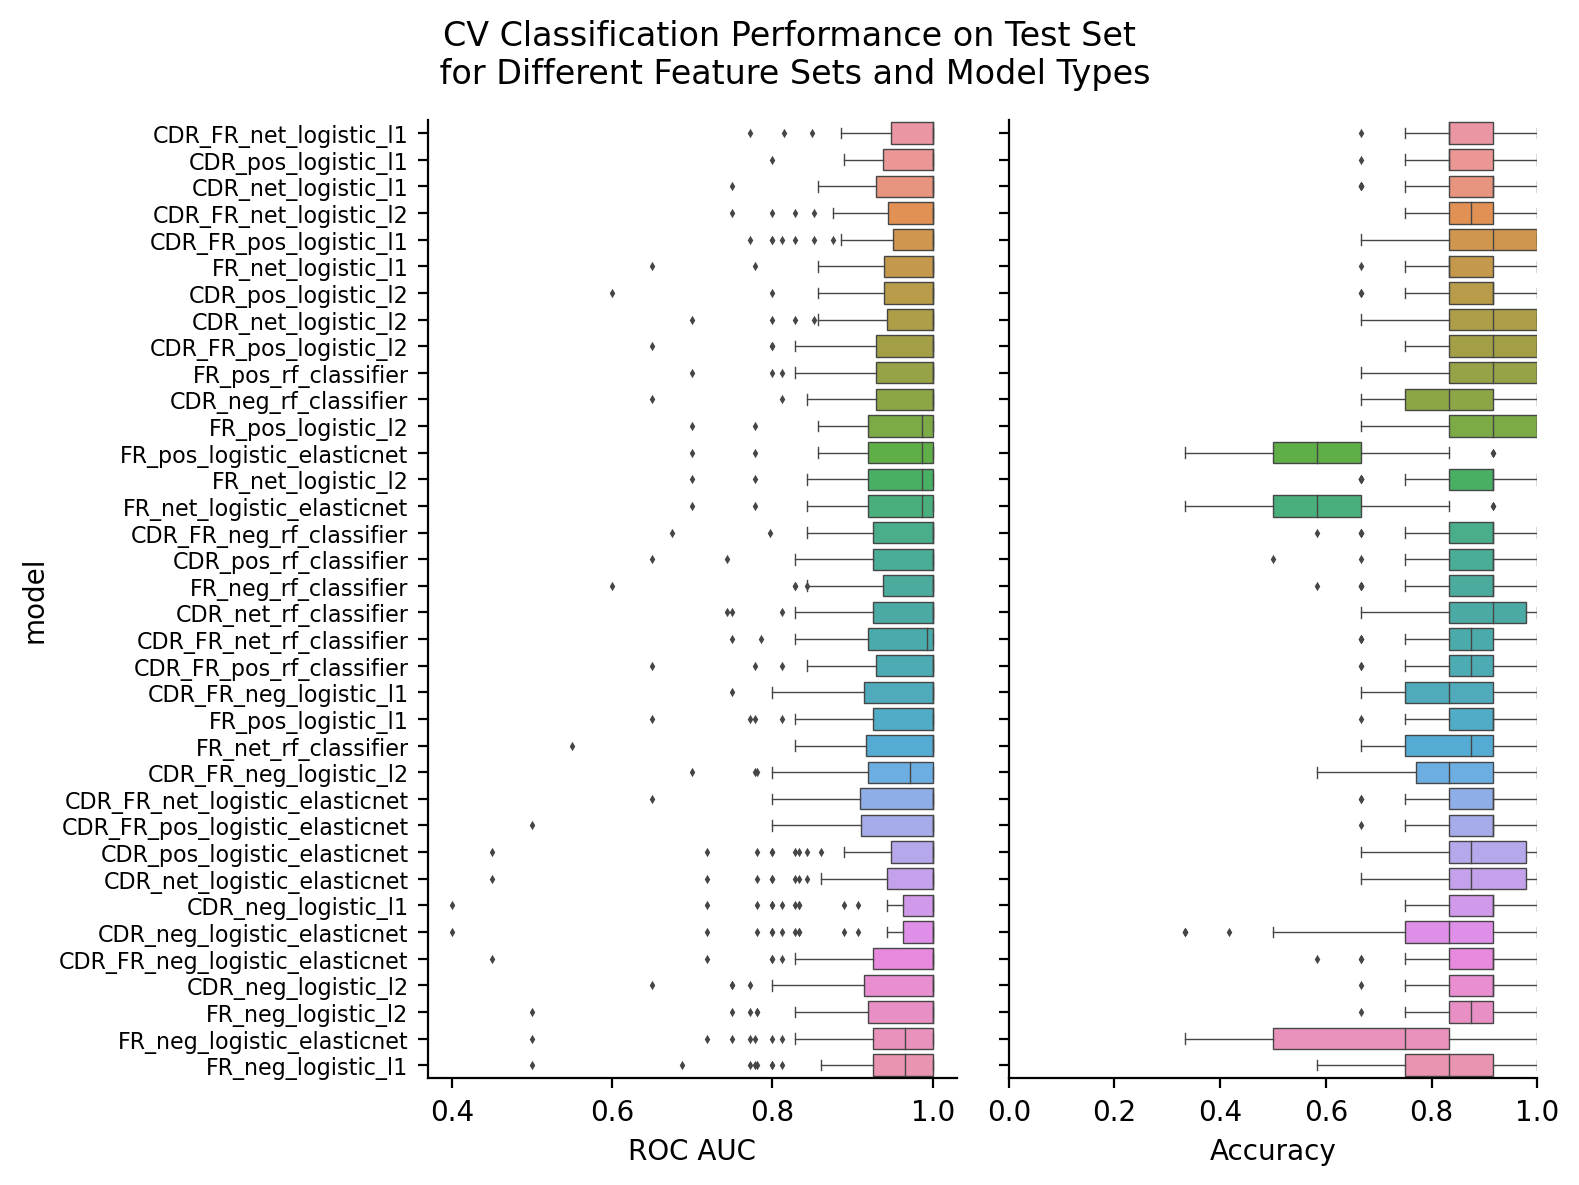

In [406]:
fig, axes = plt.subplots(1,2, figsize = (8,6))
order = classification_cv_results_df.groupby('model')['roc_auc'].mean().sort_values(ascending = False).index
ax = sns.boxplot(data=classification_cv_results_df, y='model', x='roc_auc', order = order, 
                  linewidth = 0.5, fliersize=1, ax = axes[0])
ax.set_yticklabels(size = 8, labels = ax.get_yticklabels())
ax.set(xlabel = 'ROC AUC')


ax= sns.boxplot(data=classification_cv_results_df, y='model', x='accuracy', order = order, 
                  linewidth = 0.5, fliersize=1, ax = axes[1])
ax.set_xlim(0, 1)
ax.set(yticklabels="", ylabel = '', xlabel='Accuracy')

fig.suptitle('CV Classification Performance on Test Set\n for Different Feature Sets and Model Types')

sns.despine()
plt.tight_layout()

#### Model using charges only

In [416]:
charge_data = pd.read_csv(data_path/'MPK190_v1.3_charge_counts.csv', index_col = 0)
print(len(charge_data))
charge_data.head()

69


,# new K or R,# del K or R,# new D or E,# del D or E,Total
Variant,,,,,
VIRMAB-ML-M190-R2-150/1,0,0,0,0,0
VIRMAB-ML-M190-R2-041,1,0,0,0,1
VIRMAB-ML-M190-R2-101,1,0,0,0,1
VIRMAB-ML-M190-R2-048,1,0,0,0,1
VIRMAB-ML-M190-R2-026,0,1,0,0,-1


In [424]:
train_index = X_train.index
X_charge_train = charge_data.loc[train_index]

In [452]:

def train_with_cross_validation(model,X, y, y_discrete=False ): 
    if y_discrete: 
        cv = RepeatedStratifiedKFold(random_state = 42)
        scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
    else: 
        cv = RepeatedKFold(random_state = 42)
        scoring = ['neg_root_mean_squared_error', 'r2']
    

    cv_results = cross_validate(model, X, y, cv = cv, n_jobs = -1, return_estimator=True, 
                                scoring = scoring, return_train_score=True)
    return cv_results

    

In [446]:
lr = LinearRegression()
cv_results = train_with_cross_validation(lr, X_charge_train.iloc[:,:-1], y_train[['Hep RTT']], False)
charges_RMSE = np.round(np.abs(cv_results['test_neg_root_mean_squared_error'].mean()),3)
charges_R2 = np.round((cv_results['test_r2'].mean()),3)

print(f'The mean test RMSE is {charges_RMSE} and the mean test R^2 is {charges_R2}.')

The mean test RMSE is 0.029 and the mean test R^2 is 0.6.


In [450]:
lr = LinearRegression()
cv_results2 = train_with_cross_validation(lr, pd.DataFrame(X_charge_train.iloc[:,-1]), y_train[['Hep RTT']], False)
charges_RMSE = np.round(np.abs(cv_results2['test_neg_root_mean_squared_error'].mean()),3)
charges_R2 = np.round((cv_results2['test_r2'].mean()),3)

print(f'The mean test RMSE is {charges_RMSE} and the mean test R^2 is {charges_R2} for using net charge.')

The mean test RMSE is 0.029 and the mean test R^2 is 0.577 for using net charge.


##### Now classification

In [455]:
lr = LogisticRegression()
cv_results = train_with_cross_validation(lr, X_charge_train.iloc[:,:-1],np.ravel(y_train['Label'].values), True)
auc_roc = np.round(np.abs(cv_results['test_roc_auc'].mean()),3)
accuracy = np.round((cv_results['test_accuracy'].mean()),3)

print(f'The mean ROC AUC is {auc_roc} and the mean test accuracy is {accuracy}.')

The mean ROC AUC is 0.902 and the mean test accuracy is 0.815.


In [457]:
lr = LogisticRegression()
cv_results =train_with_cross_validation(lr, pd.DataFrame( X_charge_train.iloc[:,-1]),np.ravel(y_train['Label'].values), True)
auc_roc = np.round(np.abs(cv_results['test_roc_auc'].mean()),3)
accuracy = np.round((cv_results['test_accuracy'].mean()),3)

print(f'The mean ROC AUC is {auc_roc} and the mean test accuracy is {accuracy} when using the total charge change only.')

The mean ROC AUC is 0.926 and the mean test accuracy is 0.85 when using the total charge change only.


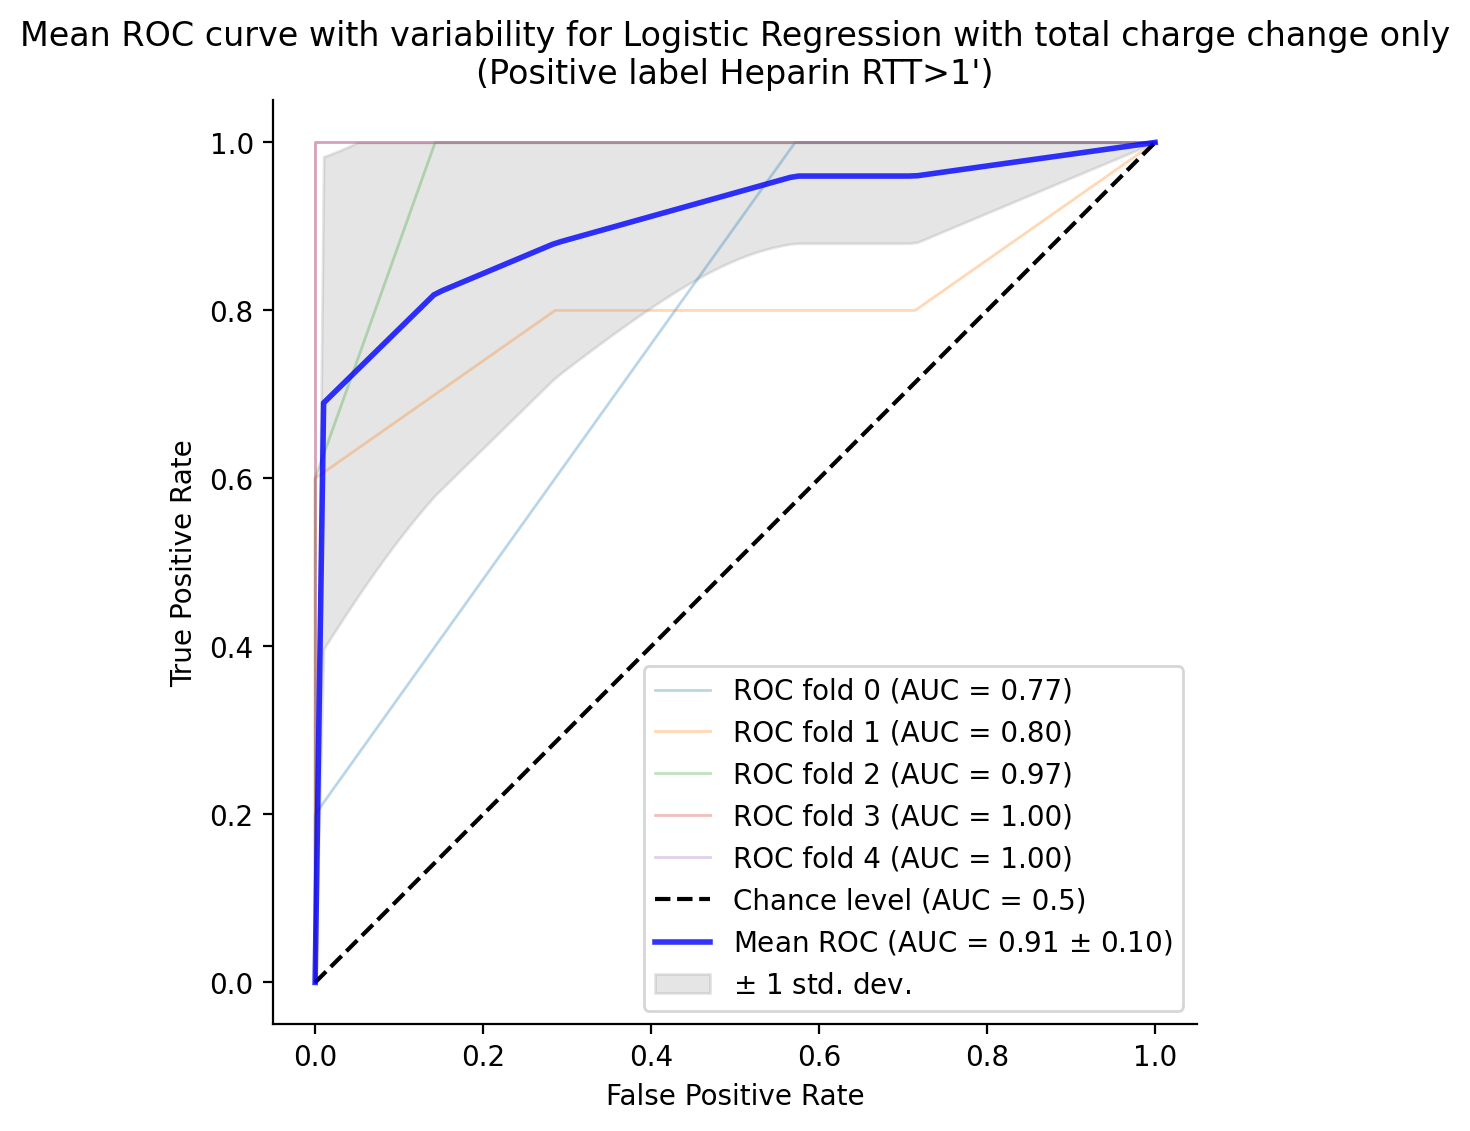

In [458]:
plot_cross_validation_classification_performance(lr, pd.DataFrame( X_charge_train.iloc[:,-1]), y_train['Label'],model_name='Logistic Regression with total charge change only', label_name='Heparin RTT>1');

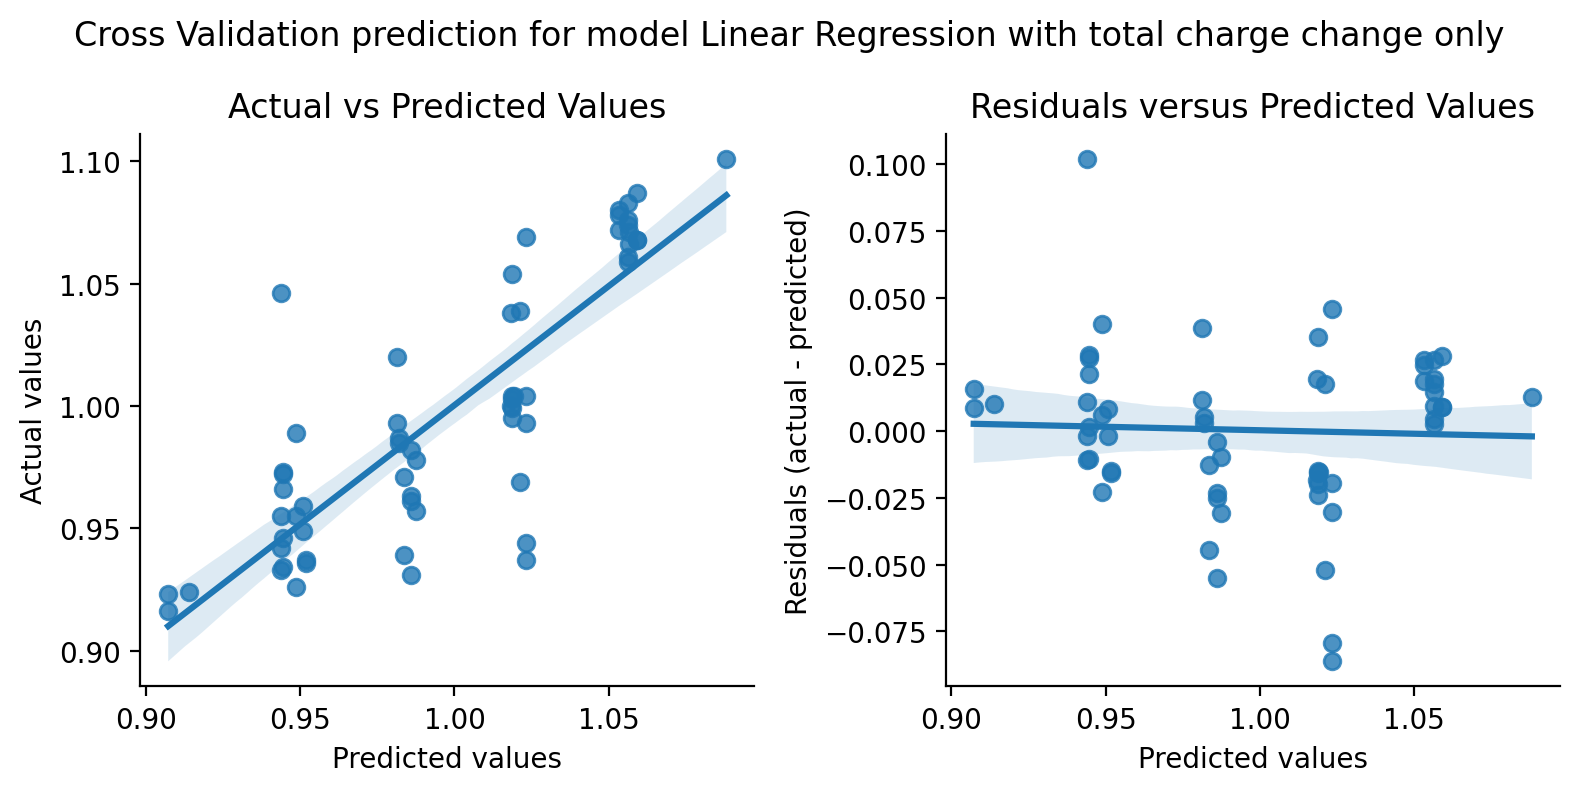

In [491]:
lm = LinearRegression()
plot_cross_validation_performance(lm, pd.DataFrame( X_charge_train.iloc[:,-1]), y_train['Hep RTT'],model_name='Linear Regression with total charge change only');